<a href="https://colab.research.google.com/github/Billy67200/Advanced-Programming/blob/main/src/04_bertopic_contraversiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unraveling Podcast Controversies with BERTopic and Generative AI

## Introduction

Welcome, fellow data explorers! In this tutorial, we'll dive into the fascinating world of podcast controversies using the power of BERTopic, Sentence Transformers, UMAP, and a touch of generative AI magic.  We're going to take a dataset of extracted controversies from podcast transcripts and turn it into insightful, visualized topics. Think of it as detective work, but instead of solving crimes, we're uncovering the hidden structure of heated debates!

We'll use a JSONL file containing information about podcast episodes, including descriptions of controversies and their associated viewpoints.  Our goal is to:

1.  **Preprocess the data:** Prepare the text data for analysis.
2.  **Build a BERTopic model:** Leverage cutting-edge NLP techniques.
3.  **Leverage Generative AI:** Use Google's Gemini model to give our topics descriptive names.
4.  **Visualize the results:** Create interactive plots to explore the topic landscape.
5. **Analyze and Save Results** Create several files for further analysis.

Let's get started!

## Setup and Dependencies

First, we need to install and import the necessary libraries.  Make sure you have the following installed:

```bash
pip install bertopic sentence-transformers umap-learn pandas scikit-learn openai
```

Now, let's import them into our notebook:

In [2]:
import openai
import pandas as pd
import json
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from bertopic.representation import OpenAI
import os
from google.colab import userdata # for use in Google Colab. Use os.getenv("YOUR_API_KEY") for local use
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

False

## Data Preparation

The `prepare_controversies_data` function takes the path to our JSONL file and transforms it into a Pandas DataFrame.  This is crucial for easy manipulation and analysis. The function reads each line of the JSONL file, extracts relevant information (like the controversy topic, description, viewpoints, and episode metadata), and combines them into a single text field.  It also handles missing values gracefully.

In [3]:
def prepare_controversies_data(jsonl_path):
    # Read JSONL file
    records = []
    with open(jsonl_path, 'r') as file:
        for line in file:
            records.append(json.loads(line))

    # Prepare controversies dataframe
    controversies_data = []
    for record in records:
        episode_info = record['episode_info']
        if 'controversies' in record:
            for controversy in record['controversies']:
                # Combine relevant text fields
                combined_text = f"{controversy['topic']} {controversy['description']}"
                if 'viewpoints' in controversy:
                    combined_text += ' ' + ' '.join(controversy['viewpoints'])

                # Store all metadata
                controversies_data.append({
                    'text': combined_text,
                    'date': episode_info['date'],
                    'podcast_name': episode_info['podcast_name'],
                    'episode_title': episode_info['title'],
                    'topic': controversy['topic'],
                    'resolution_status': controversy.get('resolution_status', 'Unknown'),
                    'viewpoints_count': len(controversy.get('viewpoints', [])),
                    'original_description': controversy['description']
                })

    return pd.DataFrame(controversies_data)

## Crafting the Perfect Prompt

Here's where we inject some generative AI goodness! We're using Google's Gemini model to automatically generate descriptive names for our topics.  This is *way* better than just looking at keywords. The `prompt` variable defines how we instruct the model.  We give it examples of how to name a controversy based on sample texts and keywords. This technique, called *few-shot prompting*, helps the model understand the desired output format. Note the strong instruction at the very end.

In [4]:
# Custom prompt for controversy topics
prompt = """This is a list of texts where each collection of texts describe a controversy or debate topic.
Provide a short, descriptive title for the controversy based on the keywords and documents provided.
Keep it focused on the core point of contention or debate.

###EXAMPLES###
---
Topic:
Sample texts from this topic:
- There's debate about whether AI should be developed rapidly or with more caution
- Some argue for quick advancement while others want more safety measures
- The tension between innovation speed and risk management remains unresolved
Keywords: ai development safety risk rapid careful innovation regulation
Topic name: AI Development Speed vs Safety Trade-offs
---

###REAL DATA###
---
Topic:
Sample texts from this topic:
[DOCUMENTS]
Keywords: [KEYWORDS]

!!!Output the topic name here only. No explanations. No intros. Just the topic name in English!!!:
"""

## Model Initialization

Now for the core of our analysis! We set up the various components of our BERTopic model:

*   **Embedding Model:** We use `nomic-ai/nomic-embed-text-v1.5` from Sentence Transformers. This model converts our text into numerical vectors (embeddings), capturing semantic meaning.  We enable `trust_remote_code=True` as required by this specific model.
*   **OpenAI Client:** We initialize the OpenAI client with our API key.  This allows us to access the Gemini model for topic naming.  We're using a Google Colab secret for the API key. If you're running this locally, use os.getenv("GOOGLE_API_KEY") or your own API key variable name.
*   **Representation Model:** We create an `OpenAI` representation model, which uses Gemini to generate topic names.  We set `delay_in_seconds` to avoid hitting rate limits. The `model` is set to a development model (`gemini-2.0-flash-exp`), but feel free to experiment with others. The `chat=True` parameter indicates we're using a chat-based model.
*  **UMAP Model**: Dimensionality reduction with UMAP. The parameters are tuned for this dataset size, reducing to 5 dimensions.
*   **BERTopic Model:**  Finally, we combine everything into a `BERTopic` model. We set `min_topic_size` to 10, meaning topics with fewer than 10 documents will be merged or considered outliers. We enable `verbose=True` to see progress updates.

In [5]:
# Set up models
embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

# Set up OpenAI client
client = openai.OpenAI(#api_key=os.getenv("GOOGLE_API_KEY"),
                       api_key = userdata.get('GOOGLE_API_KEY'),  # Using Google colab
                       base_url="https://generativelanguage.googleapis.com/v1beta/openai/")

# Create the representation model
representation_model = OpenAI(
    client,
    delay_in_seconds=5.0,
    model='gemini-2.0-flash-exp',
    prompt=prompt,
    chat=True
)

In [6]:
# Create UMAP model
umap_model = UMAP(
n_neighbors=15,  # Smaller number for smaller dataset
n_components=5,
metric='cosine',
low_memory=False
)

# Create and train BERTopic model
topic_model = BERTopic(
representation_model=representation_model,
umap_model=umap_model,
embedding_model=embedding_model,
min_topic_size=10,  # Smaller size for controversies
verbose=True
)

## Loading and Processing the Data

Let's load our data and run it through the BERTopic pipeline:

In [7]:
!wget https://rjuro.com/unistra-nlp2025/data/podcast_analyses_extract.jsonl

--2025-03-05 10:01:00--  https://rjuro.com/unistra-nlp2025/data/podcast_analyses_extract.jsonl
Resolving rjuro.com (rjuro.com)... 185.199.111.153, 185.199.108.153, 185.199.109.153, ...
Connecting to rjuro.com (rjuro.com)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4143028 (4.0M) [application/octet-stream]
Saving to: ‘podcast_analyses_extract.jsonl.1’

podcast_analyses_ex 100%[===================>]   3.95M  --.-KB/s    in 0.06s   

2025-03-05 10:01:00 (61.2 MB/s) - ‘podcast_analyses_extract.jsonl.1’ saved [4143028/4143028]



In [8]:
controversies_df = prepare_controversies_data('podcast_analyses_extract.jsonl') #Replace with your file path

In [15]:
controversies_df

,text,date,podcast_name,episode_title,topic,resolution_status,viewpoints_count,original_description
0,Trust in AI Systems The controversy surrounds ...,2023-04-17,ai_in_business,What AI Means for the Conflict in Ukraine - wi...,Trust in AI Systems,Unresolved,4,The controversy surrounds the reliability and ...
1,AI in Clinical Trials The use of AI in clinica...,2024-02-13,ai_in_business,The Power of eConsent in Healthcare Workflows ...,AI in Clinical Trials,Unresolved,3,The use of AI in clinical trials raises concer...
2,Intellectual Property and AI Training The cont...,2023-02-23,ai_in_business,Generative AI and the Future of Work Itself - ...,Intellectual Property and AI Training,Unresolved,3,The controversy revolves around the use of exi...
3,The Potential for Job Displacement The controv...,2023-02-23,ai_in_business,Generative AI and the Future of Work Itself - ...,The Potential for Job Displacement,Unresolved,3,The controversy centers on the potential for A...
4,The Impact of AI on Shared Social Experiences ...,2023-02-23,ai_in_business,Generative AI and the Future of Work Itself - ...,The Impact of AI on Shared Social Experiences,Unresolved,3,The controversy focuses on the potential for A...
...,...,...,...,...,...,...,...,...
615,Resistance to AI in Healthcare There is some r...,2024-12-18,AI Today,AI Use Case Series AI in Healthcare [AI Today...,Resistance to AI in Healthcare,Unresolved,3,There is some resistance to the adoption of AI...
616,Objectivity and Bias in AI-Generated Content T...,2024-11-20,ai_today,AI Use Case Series AI in Journalism and News ...,Objectivity and Bias in AI-Generated Content,Unresolved,3,The use of AI in news writing raises questions...
617,Echo Chambers and Filter Bubbles Personalized ...,2024-11-20,ai_today,AI Use Case Series AI in Journalism and News ...,Echo Chambers and Filter Bubbles,Unresolved,3,"Personalized news feeds, curated by AI algorit..."
618,Verification of AI-Generated Content The chall...,2024-10-30,AI Today,Essential Skills for AI-Driven Project Manager...,Verification of AI-Generated Content,Unresolved,3,The challenge of verifying the authenticity of...


In [9]:
# Prepare the texts
texts = controversies_df['text'].tolist()

In [10]:
# Fit the model
topics, probs = topic_model.fit_transform(texts)

2025-03-05 10:01:15,414 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

2025-03-05 10:07:04,588 - BERTopic - Embedding - Completed ✓
2025-03-05 10:07:04,593 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-05 10:07:19,978 - BERTopic - Dimensionality - Completed ✓
2025-03-05 10:07:19,980 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-05 10:07:20,012 - BERTopic - Cluster - Completed ✓
2025-03-05 10:07:20,021 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 13/13 [01:13<00:00,  5.68s/it]
2025-03-05 10:08:34,065 - BERTopic - Representation - Completed ✓


We now generate 2D embeddings for visualization.

In [11]:
# Create visualizations, because when we use topic_model, all of the code below was 'invisible', like a 'black box'. We do it individually to see what's inside the black box
embeddings = embedding_model.encode(texts, show_progress_bar=True)

reduced_embeddings = UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine'
).fit_transform(embeddings)

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

## Inspecting the Topics

The `get_topic_info()` method gives us a summary of the identified topics, including their generated names and representative documents. `get_document_info()` show us which topic each document belongs to.

In [12]:
# Get topic information
topic_info = topic_model.get_topic_info()
doc_info = topic_model.get_document_info(texts)

Let's print the `topic_info` to get an idea of the topics extracted:

In [14]:
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,219,"-1_AI Accuracy, Reliability, and the Role of H...","[AI Accuracy, Reliability, and the Role of Hum...",[AI Model Accuracy and Reliability There is an...
1,0,66,0_AI Data Collection vs. Privacy Rights,[AI Data Collection vs. Privacy Rights],[Data Privacy and Security The podcast discuss...
2,1,52,1_AI: Short-Term Gains vs. Long-Term Strategic...,[AI: Short-Term Gains vs. Long-Term Strategic ...,[The Hype vs Reality of AI Integration The pod...
3,2,49,2_Open Source AI Definition and Licensing Debate,[Open Source AI Definition and Licensing Debate],[Definition of Open Foundation Models The defi...
4,3,44,3_AI Model Benchmarking Validity,[AI Model Benchmarking Validity],[Benchmark Contamination The discussion raises...
5,4,43,4_LLMs: Reasoning vs. Pattern Matching & Ethic...,[LLMs: Reasoning vs. Pattern Matching & Ethica...,[Over-reliance on LLMs There is a potential da...
6,5,40,5_Balancing AI Innovation and Regulation,[Balancing AI Innovation and Regulation],[Balancing Innovation and Regulation The discu...
7,6,35,6_AI Job Displacement vs. Augmentation,[AI Job Displacement vs. Augmentation],[AI as a Job Replacement The controversy revol...
8,7,27,7_AI Bias and Fairness in Algorithms and Data,[AI Bias and Fairness in Algorithms and Data],[Bias in AI Systems The discussion highlights ...
9,8,12,8_AI Hallucinations and the Need for Accuracy,[AI Hallucinations and the Need for Accuracy],[Hallucinations and Accuracy of GenAI The pote...


## Visualizing the Topic Landscape

Now for the fun part – visualization! We use `visualize_document_datamap` to create an interactive plot showing the distribution of documents in the reduced embedding space.  Each point represents a document, and the colors correspond to different topics.  This allows us to see how the topics cluster and relate to each other. We save it as a PDF for later perusal.

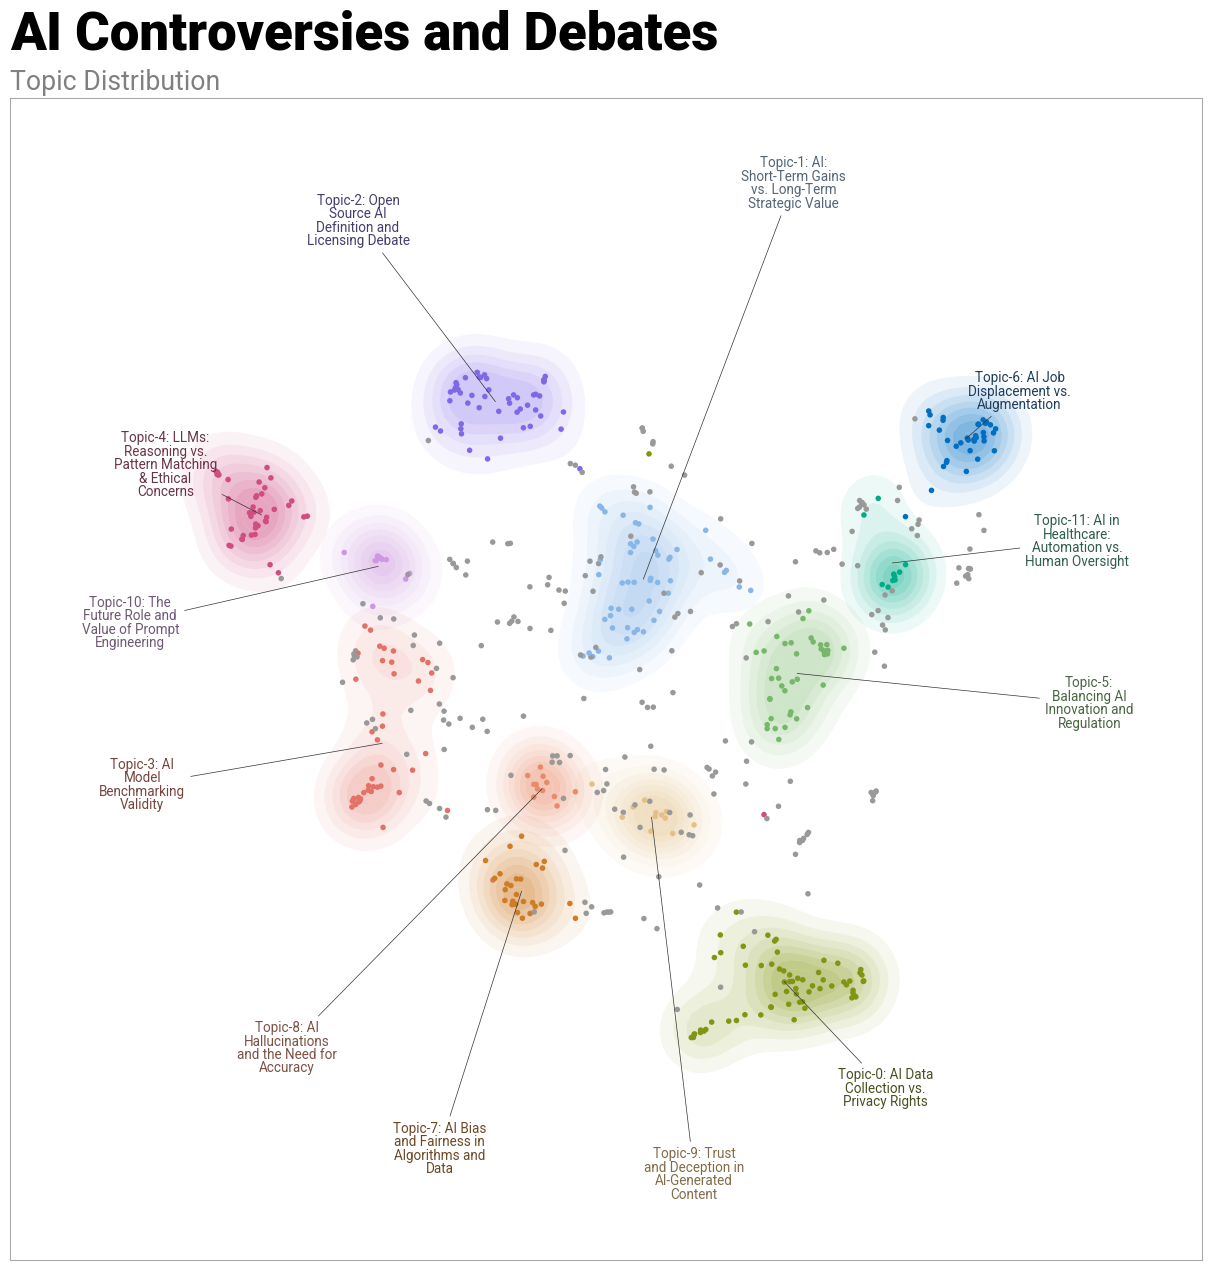

In [15]:
# Create and save visualizations
doc_map = topic_model.visualize_document_datamap(
    texts,
    reduced_embeddings=reduced_embeddings,
    title="AI Controversies and Debates",
    sub_title="Topic Distribution"
)
doc_map.savefig('controversy_document_datamap.pdf', bbox_inches="tight")

## Merging and Saving Results

To make our results more comprehensive, we merge the topic modeling output with the original controversy data.  The `merge_topic_results` function does the following:

1.  Creates a dictionary mapping topic numbers to their generated names.
2.  Resets the index of `doc_info` for proper merging.
3.  Creates a copy of the original `controversies_df`.
4.  Adds columns for `Topic`, `Topic_Name`, `Topic_Probability`, and `Is_Representative` based on the `doc_info`.

In [16]:
# After running topic modeling, add this code to merge results:
def merge_topic_results(controversies_df, doc_info, topic_info):
    # Create a mapping of topic numbers to their names
    topic_names = dict(zip(topic_info['Topic'], topic_info['Name']))

    # Reset index of doc_info to merge properly
    doc_info_reset = doc_info.reset_index()

    # Create a merged dataframe
    merged_df = controversies_df.copy()

    # Add topic information
    merged_df['Topic'] = doc_info_reset['Topic']
    merged_df['Topic_Name'] = merged_df['Topic'].map(topic_names)
    merged_df['Topic_Probability'] = doc_info_reset['Probability']

    # Add representative documents info
    merged_df['Is_Representative'] = doc_info_reset['Representative_document']

    return merged_df

In [17]:
# After topic modeling is complete:
merged_results = merge_topic_results(controversies_df, doc_info, topic_info)

We then save the merged results to a CSV file. We also create two additional summaries:

*   `topic_summary`:  Groups the results by topic and calculates statistics like the number of podcasts per topic, the distribution of resolution statuses, and the average number of viewpoints.
*   `temporal_summary`:  Analyzes the distribution of topics over time.

In [18]:
# Save comprehensive results
merged_results.to_csv('controversy_analysis_complete.csv', index=False)

# Optional: Create summary statistics
topic_summary = merged_results.groupby(['Topic', 'Topic_Name']).agg({
    'podcast_name': 'count',
    'resolution_status': lambda x: x.value_counts().to_dict(),
    'viewpoints_count': 'mean'
}).reset_index()

topic_summary.to_csv('controversy_topics_summary.csv', index=False)

# Optional: Temporal analysis
temporal_summary = merged_results.groupby(['date', 'Topic_Name']).size().unstack(fill_value=0)
temporal_summary.to_csv('controversy_temporal_analysis.csv')

## Example Usage and Further Exploration

Let's demonstrate how to load the saved results and perform some basic queries.

In [19]:
import pandas as pd

In [20]:
merged_results = pd.read_csv('controversy_analysis_complete.csv')

You can now easily inspect a specific entry:

In [21]:
merged_results['text'][0]

"Trust in AI Systems The controversy surrounds the reliability and trustworthiness of AI systems, particularly in high-stakes environments like defense. The discussion highlights that while AI can significantly enhance capabilities, it is crucial to ensure that these systems are transparent, explainable, and robust enough to avoid fatal mistakes. The challenge lies in developing AI harnesses that enforce factual accuracy and honesty, as well as creating workflows that allow users to understand and trust the AI's outputs. AI systems need to be reliable and transparent. Building trust in AI is crucial for adoption. AI harnesses must enforce factual accuracy. Users need to understand how AI systems work to trust them."

Or copy the all the texts related to a specific topic (here, topic number 9) to the clipboard, combining dates and text with the `apply` function:

In [23]:
# Combine date and text with a prefix, then join with newlines
(merged_results[merged_results['Topic']==1]
 .apply(lambda row: f"[{row['date']}] {row['text']}", axis=1)
 .to_csv('topic_1.csv',index=False)
)

And you can display the `merged_results` dataframe.

In [24]:
merged_results

,text,date,podcast_name,episode_title,topic,resolution_status,viewpoints_count,original_description,Topic,Topic_Name,Topic_Probability,Is_Representative
0,Trust in AI Systems The controversy surrounds ...,2023-04-17,ai_in_business,What AI Means for the Conflict in Ukraine - wi...,Trust in AI Systems,Unresolved,4,The controversy surrounds the reliability and ...,-1,"-1_AI Accuracy, Reliability, and the Role of H...",0.000000,False
1,AI in Clinical Trials The use of AI in clinica...,2024-02-13,ai_in_business,The Power of eConsent in Healthcare Workflows ...,AI in Clinical Trials,Unresolved,3,The use of AI in clinical trials raises concer...,11,11_AI in Healthcare: Automation vs. Human Over...,1.000000,False
2,Intellectual Property and AI Training The cont...,2023-02-23,ai_in_business,Generative AI and the Future of Work Itself - ...,Intellectual Property and AI Training,Unresolved,3,The controversy revolves around the use of exi...,0,0_AI Data Collection vs. Privacy Rights,0.569365,False
3,The Potential for Job Displacement The controv...,2023-02-23,ai_in_business,Generative AI and the Future of Work Itself - ...,The Potential for Job Displacement,Unresolved,3,The controversy centers on the potential for A...,6,6_AI Job Displacement vs. Augmentation,0.997945,False
4,The Impact of AI on Shared Social Experiences ...,2023-02-23,ai_in_business,Generative AI and the Future of Work Itself - ...,The Impact of AI on Shared Social Experiences,Unresolved,3,The controversy focuses on the potential for A...,-1,"-1_AI Accuracy, Reliability, and the Role of H...",0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...
615,Resistance to AI in Healthcare There is some r...,2024-12-18,AI Today,AI Use Case Series AI in Healthcare [AI Today...,Resistance to AI in Healthcare,Unresolved,3,There is some resistance to the adoption of AI...,11,11_AI in Healthcare: Automation vs. Human Over...,1.000000,False
616,Objectivity and Bias in AI-Generated Content T...,2024-11-20,ai_today,AI Use Case Series AI in Journalism and News ...,Objectivity and Bias in AI-Generated Content,Unresolved,3,The use of AI in news writing raises questions...,-1,"-1_AI Accuracy, Reliability, and the Role of H...",0.000000,False
617,Echo Chambers and Filter Bubbles Personalized ...,2024-11-20,ai_today,AI Use Case Series AI in Journalism and News ...,Echo Chambers and Filter Bubbles,Unresolved,3,"Personalized news feeds, curated by AI algorit...",-1,"-1_AI Accuracy, Reliability, and the Role of H...",0.000000,False
618,Verification of AI-Generated Content The chall...,2024-10-30,AI Today,Essential Skills for AI-Driven Project Manager...,Verification of AI-Generated Content,Unresolved,3,The challenge of verifying the authenticity of...,9,9_Trust and Deception in AI-Generated Content,1.000000,True


## Conclusion

And there you have it! We've successfully used BERTopic and generative AI to explore and visualize podcast controversies. We've built a robust pipeline for processing text data, extracting meaningful topics, and presenting the results in an accessible way.  This framework can be adapted to analyze various types of textual data, opening up exciting possibilities for research and exploration. Remember to explore the interactive visualizations and saved CSV files to gain deeper insights into the data. Happy topic modeling!